# Application de la k-anonymisation sur Transparence Santé

## 1) Téléchargement des données

Le fichier peut être téléchargé à cette adresse : https://www.data.gouv.fr/fr/datasets/transparence-sante-1/  
ou directement sur : https://www.transparence.sante.gouv.fr/exports-etalab/exports-etalab.zip  

Ce jeu de données contient environ 2 millions de lignes. Le fichier exports-etalab.zip contient :
* Le jeu de données  
* La présentation du jeu de données  
* La licence d'utilisation
     
  
 
Le fichier INSEE pour l'enrichissement des données peut être téléchargé ici : http://www.insee.fr/fr/themes/detail.asp?reg_id=99&ref_id=equip-serv-medical-para
ou directement sur : http://www.insee.fr/fr/ppp/bases-de-donnees/donnees-detaillees/equip-serv-medical-para/equip-serv-medical-para-com-2015.zip

In [1]:
%matplotlib inline

In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from anonymizer.config_anonymizer import config
import os
import io

path_data = config['PATH']['TRANSPARENCE']

nbre_lignes = 50000
avantages = pd.read_csv(path_data, sep = ";", nrows = nbre_lignes, low_memory = False)

On ne charge que les 50 000 premières lignes par souci de bonnes performances de calcul. C'est selon la configuration de votre machine.

## 2) Importation des modules

In [3]:
#!/usr/bin/env python
"""
A partir des fonctions du dépôt anonymizer, ce fichier va notamment vous permettre de :

1. **Importer** les données de la base Transparence Santé.
2. **Nettoyer** les variables et sélectionner celles à anonymiser
3. **Anonymiser** les données selon un procédé de K-anonymisation
4. **Compléter** avec les données INSEE afin d'en mesurer la plus-value.

"""

from import_insee import (expand_insee,
                                     nbre_modif)

from anonymizer.anonymity import (get_k, get_anonymities,
                                  less_anonym_groups,
                                 all_local_aggregation)
from anonymizer.diversity import (get_l,
                                  get_diversities,
                                  diversity_distribution,
                                  less_diverse_groups
                                )
from anonymizer.transformations import (first_letters,
                                       last_letters,
                                       local_aggregation)
from anonymizer.transformations import str_drop
from anonymizer.anonymDF import AnonymDataFrame


## 3) Nettoyage de la base

Pour commencer, on va séparer les personnes morales (entreprises, hôpitaux, etc.) des personnes physiques. L'anonymisation ne concerne en effet que ces dernières.

In [4]:
# === Séparation personnes physiques/morales ===  
# On ne traite pas le cas des personnes morales


code_personne_physique = ['[PRS]','[ETU]']
personnes_physiques = avantages[avantages['benef_categorie_code'].isin(code_personne_physique)]
personnes_morales = avantages[~avantages['benef_categorie_code'].isin(code_personne_physique)]
avantages = personnes_physiques

Nous pouvons maintenant procéder à une première étape de la réflexion, qui consiste à reconnaître les variables identifiantes, à les supprimer puis à traiter les quasi-identifiants.  
* Les prénom, nom, adresse et ville du bénéficiaire sont des informations directement idenfitiantes, c'est-à-dire qui peuvent directement identifier un individu. 
* On considère toutes les autres variables comme des quasi-identifiants. 


<table>
    <tr>
        <td>**Comment reconnaître les quasi-identifiants ? **Un quasi-identifiant représente une information qui, une fois combinée avec d’autres quasi-identifiants, permet d’identifier une personne. Un exemple classique est celui du triplet {date de naissance, genre, code postal}, qui a permis d’identifier 80% des Américains par croisement avec les listes électorales. Dans ce cas, la date de naissance, le genre et le code postal sont des quasi-identifiants ; leur combinaison est appelée clef d’identification.  
        **Dans notre cas, nous considérons l'ensemble des variables restantes comme des quasi-identifiants** : si je retrouve le ticket de caisse d'un ami, le montant de l'avantage me permet de l'identifier dans la base ; si je sais que mon médecin a déjeuné avec un représentant de Sanofi, la nature de l'avantage me permet potentiellement de le retrouver dans la base, etc.</td>
    </tr>
</table>




Avant de lancer l'anonymisation sur les quasi-identifiants ainsi repérés, il faut d'abord leur appliquer un traitement spécifique. Par exemple :  
* **Le code postal** étant directement pour un professionnel de santé exerçant dans une petite ville, nous transformons le code postal en code départemental - on ne garde que les deux premiers chiffres du code postal.
* **Le montant précis de l'avantage** en son équivalent décile (ce qui nous permet d'uniformiser les modalités de cette variable).
* **La date du jour** de l'avantage est un élément trop précis dans le cadre d'une anonymisation : si mon médecin reçoit un avantage le 26 février 2015, il est probable qu'il soit le seul à en avoir reçu un ce jour-là. On décide donc de ne garder que l'année (le semestre est aussi indiqué par une autre variable).

In [5]:
# === transformatiosn préalables ===

# * On transforme les CP en indicateurs régionaux
avantages['benef_dept'] = first_letters(avantages['benef_codepostal'],2)

# * On supprime les CP peu orthodoxes
erreur_CP = ['0', '', 'IN']
avantages.loc[avantages['benef_dept'].isin(erreur_CP), 'benef_dept'] = np.nan
erreur_pays = ['[RE]','[GP]']
avantages.loc[avantages['benef_pays_code'].isin(erreur_pays), 'benef_pays_code'] = '[FR]'

# * On homogénéise les valeurs manquantes ou tierces par la mention "non-renseigné"
avantages = avantages.fillna('non renseigné')
to_replace = ['[AUTRE]', '']
avantages.replace(to_replace, 'non renseigné', inplace=True)

# * On transforme la valeur des conventions/avantages en leur équivalent décile (uniformisation)

avantages['avant_montant_ttc'] = avantages['avant_montant_ttc'].astype(float)
avantages['montant_décile'] = pd.qcut(avantages.avant_montant_ttc,10)

# * On transforme la date (signature des avantages) en mois/année (le jour est trop identifiant)

avantages['date'] = last_letters(avantages['avant_date_signature'],6)

avantages['avant_nature'] = avantages['avant_nature'].str.lower()


# * On supprime d'abord les variables identifiantes afin de ne garder que les variables quasi-identifiantes

variables_supprimees = [
                        'avant_convention_lie', 
                        'identifiant_type', 
                        'benef_qualification', 
                        'benef_speicalite_libelle', 
                        'ligne_rectification',
                        'denomination_sociale',
                        'benef_titre_libelle',
                        'benef_prenom',
                        'benef_nom', 
                        'benef_adresse1', 
                        'benef_adresse2',
                        'benef_adresse3',
                        'benef_adresse4',
                        'benef_identifiant_valeur',
                        'benef_ville',
                        'benef_etablissement_ville',
                        'categorie',
                        'benef_qualite_code',
                        'benef_codepostal',
                        'benef_etablissement_codepostal',
                        'ligne_identifiant',
                        'pays',
                        'benef_denomination_sociale',
                        'benef_objet_social',
                        'avant_date_signature',
                        'avant_montant_ttc',
                        'benef_etablissement'
                       ]

avantages = avantages.drop(variables_supprimees,1)

avantages['montant_décile'] = avantages['montant_décile'].astype(str)
avantages['date'] = avantages['date'].astype(str)

## 4) Algorithme

* **On définit d'abord les variables à traiter**. Dans le cas classique, il serait bienvenu de prendre l'ensemble des variables présentes dans la base. Ici, étant donné que l'on va compléter par la suite cette base par des informations INSEE, on ne prend en compte que les variables qui sont communes à la base initiale et à la base INSEE. On les **stocke dans la liste "ordre_aggregation"**. Attention, l'ordre des variables est important. 

<table>
    <tr>
        <td>**Pourquoi ordonner les variables ?** Les modifications effectuées sur la base par l’algorithme sont dépendantes de l’ordre de traitement des variables. Il faut donc s’interroger en amont sur la façon dont on va les renseigner dans l’algorithme : les dernières variables sont les plus susceptibles d'être modifiées. Par exemple, si on a [département, spécialité, montant], on va d'abord regrouper les individus par départements, puis par spécialité, puis par montant. Il y a donc plus de chances d'avoir des groupes supérieurs à k individus si l'on regroupe les lignes par départements plutôt que si l'on regroupe celles d'un même département au sein des lignes ayant la même spécialité et le même montant.</td>
    </tr>
</table>

In [6]:
# On définit ici les variables traitées pour l'anonymisation
var = avantages.columns.tolist()
var.remove('ligne_type')
var.remove('avant_nature')

In [7]:
ordre_aggregation = [
    'benef_dept',
    'benef_categorie_code',
    'qualite',
    'benef_pays_code',
    'benef_titre_code',
    'benef_identifiant_type_code'
    ]

On peut maintenant lancer l'algorithme, en définissant la classe et le k (k=5).  

* On va anonymiser l'ensemble des variables selon la méthode **"regroup_with_smallest"**, *i.e.* regrouper la modalité en minorité avec une modalité dont l'effectif est le plus petit, mais supérieur à k. Exemple : regrouper le département 01 (3 lignes) avec le département 02 (6 médecins), plutôt qu'avec 03 (12 médecins), car 12 > 6.  
* A l'exception de la date, que l'on va anonymiser suivant la méthode **"with_closest"** : regrouper une année avec l'année la plus proche (2012 avec 2011 ou 2010, plutôt qu'avec 1983).

In [8]:
Avantages = AnonymDataFrame(avantages.copy(),  ordre_aggregation, unknown='non renseigné')
k = 5

def aggregation_serie(x):
    return(local_aggregation(x, k, 'regroup_with_smallest', 'non renseigné'))

def aggregation_year(x):
    return(local_aggregation(x, k, 'with_closest', 'non renseigné'))
    
method_anonymisation = [(name, aggregation_serie) for name in ordre_aggregation[:-1]] + [('date', aggregation_year)]

In [9]:
Avantages.local_transform(method_anonymisation, k)

On compte le nombre de modalités modifiées (et par symétrie, le nombre de modalités laissées en l'état) afin d'établir par la suite une comparaison entre les deux méthodes (méthode classique et chargement des données INSEE).

In [10]:
modalites_modifiees = (Avantages.anonymized_df.values != avantages.values).sum()
modalites_intactes = (Avantages.anonymized_df.values == avantages.values).sum()
print("{0:.1f}% des valeurs ont été modifiées".format(100*modalites_modifiees/len(Avantages.df)))

42.0% des valeurs ont été modifiées


## 5) Importation des données INSEE

La base Transparence Santé ne comporte que les personnes ayant eu un avantage ou une convention au cours des dernières années. Il peut être intéressant de considérer l'ensemble des effectifs des professions médicales, ayant eu ou non un avantage au cours des derniers mois, ce qui pourrait rendre l'anonymisation plus facile.


L'INSEE met à libre disposition une base qui présente les effectifs départementaux des professions médicales. On peut donc s'en servir pour compléter la Base Transparence Santé. Les nouvelles lignes ajoutées comporteront seulement le code de la spécialité (ou la qualité, selon les cas) ainsi que le département.

Pour commencer, on construit un dictionnaire reliant les professions INSEE aux codes de spécialité de la base Transparence Santé.

In [11]:
# construction d'un dictionnaire reliant les professions (INSEE) aux professions (Transparence Santé)

annuaire = {
    'Médecin omnipraticien' : ['benef_specialite_code', '[SM54]'],
    'Spécialiste en cardiologie' : ['benef_specialite_code', '[SM04]'],
    'Spécialiste en dermatologie vénéréologie' : ['benef_specialite_code', '[SM15]'],
    'Spécialiste en gynécologie médicale' : ['benef_specialite_code', '[SM19]'],
    'Spécialiste en gynécologie obstétrique' : ['benef_specialite_code', '[SM20]'],
    'Spécialiste en gastro-entérologie hépatologie' : ['benef_specialite_code', '[SM24]'],
    'Spécialiste en psychiatrie' : ['benef_specialite_code', '[SM42]'],
    'Spécialiste en ophtalmologie' : ['benef_specialite_code', '[SM38]'],
    'Spécialiste en oto-rhino-laryngologie' : ['benef_specialite_code', '[SM39]'],
    'Spécialiste en pédiatrie' : ['benef_specialite_code', '[SM40]'],
    'Spécialiste en pneumologie' : ['benef_specialite_code', '[SM41]'],
    'Spécialiste en radiodiagnostic et imagerie médicale' : ['benef_specialite_code', '[SM44]'],
    'Spécialiste en stomatologie' : ['benef_specialite_code', '[SM50]'],
    'Chirurgien dentiste' : ['qualite', 'Chirurgien-dentiste'],
    'Sage-femme' : ['qualite', 'Sage-femme'],
    'Infirmier' : ['qualite', 'Infirmier'],
    'Masseur kinésithérapeute' : ['qualite', 'Masseur-kinésithérapeute'],
    'Orthophoniste' : ['qualite', 'Orthophoniste'],
    'Orthoptiste' : ['qualite', 'Orthoptiste'],
    'Pédicure-podologue' : ['qualite', 'Pédicure-podologue'],
    'Audio prothésiste' : ['qualite', 'Audio prothésiste'],
    'Ergothérapeute' : ['qualite', 'Ergothérapeute'],
    'Psychomotricien' : ['qualite', 'Psychomotricien']
}

On charge ensuite les données.

In [12]:
path_data_insee = config['PATH']['INSEE']

names = pd.read_excel(path_data_insee, encoding = "ISO-8859-1", skiprows=4, skip_footer=36000).columns
insee_init = pd.read_excel(path_data_insee, encoding = "ISO-8859-1", skiprows=5, headers=None, names=names)

insee_init['Département'] = insee_init['Département'].astype(str)
insee_init['Région 2016'] = insee_init['Région 2016'].astype(str)

insee_init['Département'] = first_letters(insee_init['Département'],2)

In [13]:
# On fusionne les départements d'Outre-mer dans une seule catégorie (trop identifiant, sinon)  

outremer = ['1','2','3','4','6']
insee_init.loc[insee_init['Région 2016'].isin(outremer), 'Région 2016'] = 1

list_région = insee_init['Région 2016'].unique().tolist()

insee = insee_init.copy()

var_écartées = ['Région', 'Région 2016', 'CODGEO', 'Libellé commune ou ARM']
insee = insee.drop(var_écartées,1)

Puis on ajoute les données aux données Transparence Santé.

In [14]:
g = insee.groupby('Département')

expanded_insee = expand_insee(g, annuaire, avantages)

expanded_insee.columns = avantages.columns.tolist()
avantages_total = pd.concat([avantages, expanded_insee]).reset_index()
avantages_total = avantages_total.drop('index',1)

# avantages_total est donc constituée de la base Transparence Santé, complétée par les données INSEE

## 6) Algorithme (avec base enrichie)

In [15]:
# === On anonymise (données enrichies) ===

# On fait bien attention à anonymiser de façon "regroup" les variables, 
# sauf la date pour laquelle on choisit la méthode "year"

Avantages_avec_insee = AnonymDataFrame(avantages_total.copy(),  ordre_aggregation, unknown='non renseigné')

Avantages_avec_insee.local_transform(method_anonymisation, k, force_unknown='Forcer')
Avantages_avec_insee.df = Avantages_avec_insee.anonymized_df

In [16]:
table = Avantages_avec_insee.df[Avantages_avec_insee.df['ligne_type']=='[A]']
modalites_modifiees_avec_insee = (table.values != avantages_total[avantages_total['ligne_type']=='[A]'].values).sum()
modalites_intactes_avec_insee = (table.values == avantages_total[avantages_total['ligne_type']=='[A]'].values).sum()
print("{0:.1f}% des valeurs ont été modifiées".format(100*modalites_modifiees_avec_insee/len(table)))

41.6% des valeurs ont été modifiées


## 7) Comparaison des deux méthodes

Variable par variable, on va compter le nombre de modifications effectuées. Le graphique synthétisant ces statistiques est le suivant :

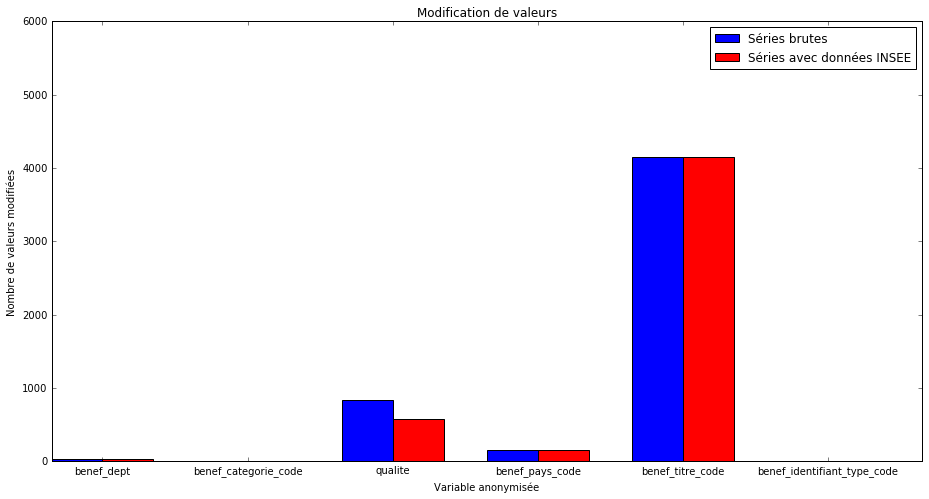

In [17]:
# === On va maintenant comparer par variables le taux de remplacement ===


modif_par_var_1 = []
for variable in ordre_aggregation :
    modif_par_var_1.append((Avantages.anonymized_df[variable] != avantages[variable]).sum())

modif_par_var_2 = []
for variable in ordre_aggregation :
    modif_par_var_2.append((Avantages_avec_insee.anonymized_df[variable][Avantages_avec_insee.df['ligne_type']=='[A]'] != avantages_total[variable][avantages_total['ligne_type']=='[A]']).sum())


n_groups = len(ordre_aggregation) # data to plot

fig, ax = plt.subplots(figsize=(13,7)) # create plot


index = np.arange(n_groups)
bar_width = 0.35
opacity = 1

rects1 = plt.bar(index, modif_par_var_1, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Séries brutes')


rects2 = plt.bar(index + bar_width, modif_par_var_2 , bar_width,
                 alpha=opacity,
                 color='r',
                 label='Séries avec données INSEE')

plt.ylim(0, 6000) 


plt.xlabel('Variable anonymisée')
plt.ylabel('Nombre de valeurs modifiées')
plt.title('Modification de valeurs')
plt.xticks(index + bar_width, ordre_aggregation)
plt.legend()

plt.tight_layout()
plt.show()

Ce graphique est plus lisible que le premier : on y voit que l'importation de l'INSEE a un impact significatif sur le nombre de modalités modifiées, bien que cet effet soit relativement faible. En particulier, cela permet de diminuer de 30% le nombre de modalités modifiées.